Final Project : Credit Card Fraud Detection  
Source : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?fbclid=IwAR0cE44LnzPeueP1CDPSbOJvwizZIStTZTRFqBo12RAQ0Tdj3FXs0S1v3BA
 
 Name: Nishant Shrestha and Tung Tran  
 Class: CSCI 349 SP 2023  
 Instructor: Dr. Brian King  
 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score,roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_predict

2023-05-02 14:12:06.779874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 14:12:06.864080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib
2023-05-02 14:12:06.864094: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-02 14:12:06.882183: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-02 14:12:08.121090: W tens

In [2]:
df_fraud = pd.read_csv('creditcard.csv')
df_fraud.info()
%config Completer.use_jedi = False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



## Variable description
**Time** contains the seconds elapsed between each transaction and the first transaction in the dataset.    
**Amount** is the credit transaction Amount.    
**V1-V28** undisclosed variables transformed using PCA.  
  
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. More so, a peak at the original dataset shows us that most of the variables have more than 8 significant figures. Thus, we also choose not to downcast our data. Only the **Time** vaiable is downcasted. This variable represent the time elapsed after the first transaction in the dataset. We choose to ignore this variable in most of our models as we believe this variable is backward looking and predictions made of the future wouldn't be influenced by the realization we have. 


# Setting up variables to the correct types

In [3]:
df_fraud['Time'] = df_fraud.Time.astype(int)
df_fraud['Time'] = pd.to_numeric(arg =df_fraud['Time'], downcast = 'integer' )
df_fraud.Class = pd.Categorical(df_fraud.Class)
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Time    284807 non-null  int32   
 1   V1      284807 non-null  float64 
 2   V2      284807 non-null  float64 
 3   V3      284807 non-null  float64 
 4   V4      284807 non-null  float64 
 5   V5      284807 non-null  float64 
 6   V6      284807 non-null  float64 
 7   V7      284807 non-null  float64 
 8   V8      284807 non-null  float64 
 9   V9      284807 non-null  float64 
 10  V10     284807 non-null  float64 
 11  V11     284807 non-null  float64 
 12  V12     284807 non-null  float64 
 13  V13     284807 non-null  float64 
 14  V14     284807 non-null  float64 
 15  V15     284807 non-null  float64 
 16  V16     284807 non-null  float64 
 17  V17     284807 non-null  float64 
 18  V18     284807 non-null  float64 
 19  V19     284807 non-null  float64 
 20  V20     284807 non-null  f

In [10]:
df_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000



**NOTE:** Since most of the models we will be using with this dataset are influenced by distance measures to some extent, we have standardized all of our variables (code is shown later duting modeling)

In [5]:
df_fraud.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

**NOTE:** Our target vaiables is binary in nature with 1 representing fraud and vice-versa. We can clearly see that the dataset is highly unbalanced with only 492 fraud activity. As a result, any simple performance metric, such as the accuracy of a model, won't be a good indicator of how our model will perform. We should note that metrics that prioritize minimizing false positives are highly recommended for predictive models where the cost of false positives is high, including credit card fraud detection models. Such metrics include precision, f1, and the AUC. Moving on, we will keep this in mind.

## Exploratory Data Analysis

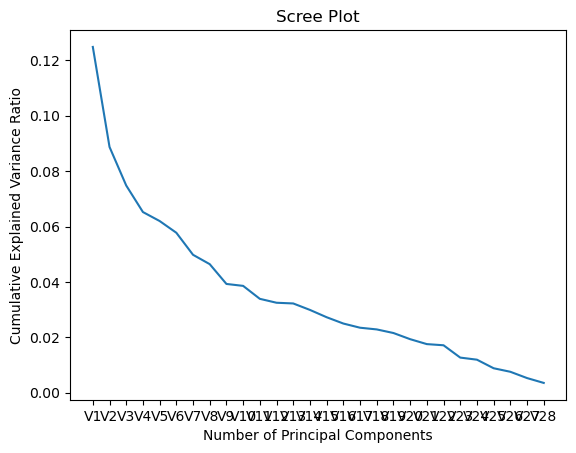

In [6]:

# generating a scree plot for the PCA transformed columns

variance = np.var(df_fraud.iloc[:,1:29], axis=0)
explained_variance_ratio = variance / np.sum(variance)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(explained_variance_ratio)
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()



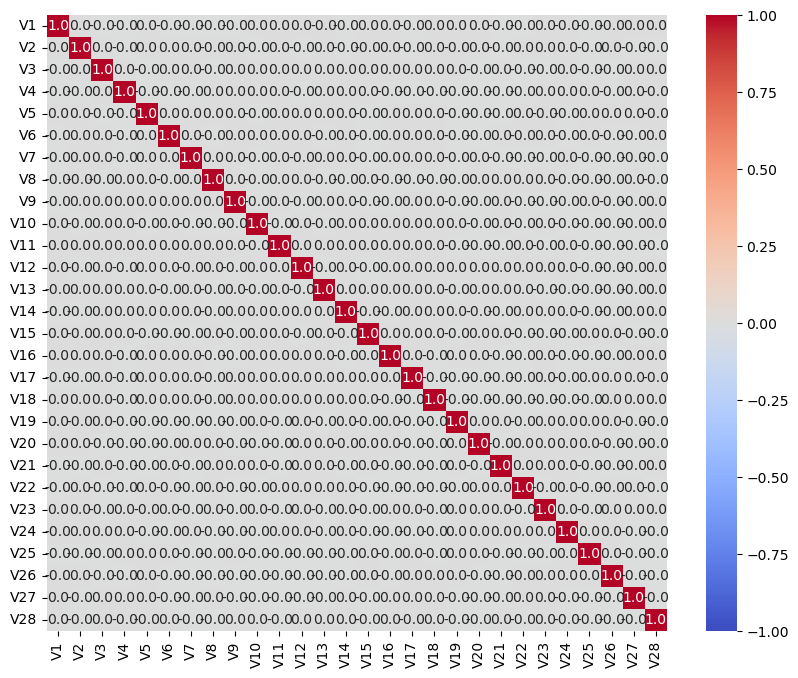

In [7]:
# correlation plot
plt.figure(figsize=(10,8))
sns.heatmap(df_fraud.iloc[:,1:29].corr(),
            center=0, vmin=-1, vmax=1, cmap="coolwarm",
            annot=True, fmt=".1f")
plt.show()

**NOTE:** Looking at the correlations between all the PCA transformed variables, we can confirm that these variables have been properly PCA transformed, since none of them are coorelated to each other

# Data Pre-processing

In [4]:
# Note, we are not using the time variable for the majority of our models. 
y = df_fraud.Class #traget class which is binary
X = df_fraud.iloc[:,1:30] # v1 till amount
X,y = shuffle(X,y, random_state=0)

# standardizing the independent variables
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index = X.index)

# setting up the training and testing variables, we use 70% of the data for training and the rest for testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)


## Modeling

In [11]:
# A neural network implementation
num_hidden = 300
inputs = keras.Input(shape=(X_scaled.columns.size,))
layer1 = Dense(num_hidden, activation = 'relu')(inputs)
layer2 = Dense(num_hidden, activation = 'relu')(layer1)
outputs = Dense(1,activation="sigmoid")(layer2)
model = keras.Model(inputs=inputs, outputs=outputs, name="credit_model")
model.summary()

Model: "credit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 300)               9000      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 99,601
Trainable params: 99,601
Non-trainable params: 0
_________________________________________________________________


2023-05-01 15:59:15.193841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 15:59:15.194005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib
2023-05-01 15:59:15.194719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib
2023-05-01 15:59:15.195592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/rem

**NOTE:** Our choice of our loss function depended on our classifier. Since, we have a binary classifier, it seemes appropriate to use a 'binary cross entropy' loss function. We also chose to have two layers in our hidden layer, as having anymore than two layers seems redundant in enhancing learning, according to the literature. Finally, we've also opted to have 300 neurons per hidden layer, and accordingly used 'reLus' as our activation function. Again, the literature points out that this particular activation function is suitable for decently large neural networks. Finally, we have a 70:30 train-test split and run the model for 10 epochs with each batch size holding 500 observations. 

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['AUC', 'Precision', 'Recall'])

In [14]:

history = model.fit(X_train, y_train, epochs=10, batch_size=500, validation_data=(X_test, y_test))



Epoch 1/10
399/399 [==============================] - 2s 3ms/step - loss: 0.0108 - auc: 0.8762 - precision: 0.6571 - recall: 0.6142 - val_loss: 0.0034 - val_auc: 0.9408 - val_precision: 0.8652 - val_recall: 0.7871
Epoch 2/10
399/399 [==============================] - 1s 2ms/step - loss: 0.0029 - auc: 0.9516 - precision: 0.8691 - recall: 0.7685 - val_loss: 0.0031 - val_auc: 0.9443 - val_precision: 0.8533 - val_recall: 0.8258
Epoch 3/10
399/399 [==============================] - 1s 2ms/step - loss: 0.0025 - auc: 0.9637 - precision: 0.8935 - recall: 0.7715 - val_loss: 0.0032 - val_auc: 0.9476 - val_precision: 0.9130 - val_recall: 0.8129
Epoch 4/10
399/399 [==============================] - 1s 2ms/step - loss: 0.0022 - auc: 0.9668 - precision: 0.9097 - recall: 0.7774 - val_loss: 0.0046 - val_auc: 0.9280 - val_precision: 0.9412 - val_recall: 0.7226
Epoch 5/10
399/399 [==============================] - 1s 2ms/step - loss: 0.0022 - auc: 0.9698 - precision: 0.8885 - recall: 0.7804 - val_loss: 

2671/2671 [==============================] - 2s 558us/step


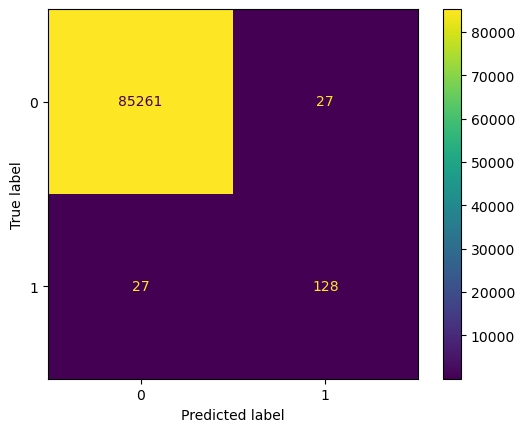

f-1 score:  0.8258064516129032


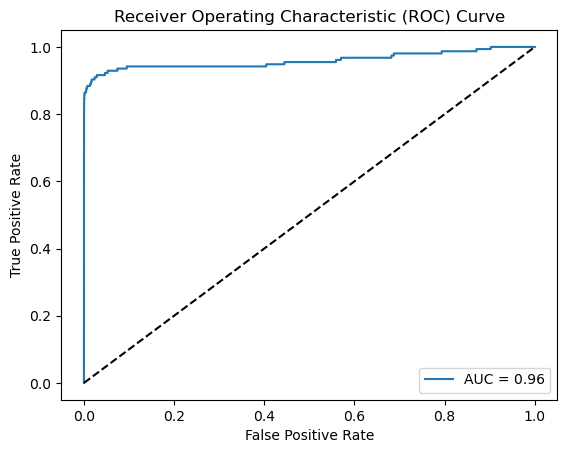

In [15]:


y_pred  = history.model.predict(X_test)

y_pred_class = np.round(y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class)
plt.show()

print('f-1 score: ',f1_score(y_test, y_pred_class))

# compute the false positive rate, true positive rate, and corresponding thresholds

# use probailities instead of the actual prediction
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**NOTE**We've obtained an f-1 score of 83% which is decent. Also, the ROC curve looks satisfactory. Now, we will use a grid search algorithm to optimize our hyperparameters.

In [14]:
def create_keras_model(num_hidden, activation):

    
    inputs = keras.Input(shape=(X_scaled.columns.size,))
    # our hidden layer is parameterized
    layer1 = Dense(num_hidden, activation=activation)(inputs)
    layer2 = Dense(num_hidden, activation=activation)(layer1)
    # we have a 3-class problem, and we'll hard-code softmax activation
    outputs = Dense(1,activation="sigmoid")(layer2)
    
    # Build our model
    model = Model(inputs=inputs, outputs=outputs, name="model_1")

    return model

Unfortunately, we were not able to use the f1-metric to run a gridsearch using a neural network due to the limitations of the scikit wrapper for the keras class. We even tried defining our own custom metric but it didn't work out. Even traditional metrics including precision aren't passable. As such, we will use accuracy to optimize our network. Although, accuracy isn't ideal, we are hoping that the model we obtain will also result into better results in other mertics including f1. 

In [34]:

param_grids = { 'optimizer' : ['adam','sgd'],'model__num_hidden':[50,100],'model__activation':['relu'], 'epochs' : [5,8, 10], 'batch_size' : [10,100,1000]}

scoring = {'f1_score': make_scorer(f1_score)}

clf = KerasClassifier(model=create_keras_model, 
                      verbose=2,
                      loss='binary_crossentropy',
                     metrics = ["accuracy"])


grid = GridSearchCV(clf, param_grid=param_grids,cv= 5,verbose = 2, n_jobs = -1)

In [ ]:
grid_result = grid.fit(X_scaled,y)
print("Best hyperparameters: ",grid_result.best_params_)
print("best score: ", grid_result.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=10, epochs=5, model__activation=relu, model__num_hidden=50, optimizer=sgd; total time=   0.3s
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=100, optimizer=adam; total time=   0.3s
[CV] END batch_size=10, epochs=10, model__activation=relu, model__num_hidden=50, optimizer=sgd; total time=   0.3s
[CV] END batch_size=100, epochs=5, model__activation=relu, model__num_hidden=50, optimizer=adam; total time=   0.3s
[CV] END batch_size=100, epochs=5, model__activation=relu, model__num_hidden=100, optimizer=sgd; total time=   0.3s
[CV] END batch_size=100, epochs=8, model__activation=relu, model__num_hidden=100, optimizer=adam; total time=   0.3s
[CV] END batch_size=100, epochs=10, model__activation=relu, model__num_hidden=50, optimizer=sgd; total time=   0.3s
[CV] END batch_size=1000, epochs=5, model__activation=relu, model__num_hidden=50, optimizer=adam; total time=   0.2s
[CV] END ba

/usr/remote/apps/anaconda/2022.05/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=10, epochs=5, model__activation=relu, model__num_hidden=100, optimizer=sgd; total time= 3.9min
Epoch 1/8
[CV] END batch_size=10, epochs=5, model__activation=relu, model__num_hidden=100, optimizer=sgd; total time= 3.9min
Epoch 1/8
[CV] END batch_size=10, epochs=5, model__activation=relu, model__num_hidden=100, optimizer=sgd; total time= 3.9min
Epoch 1/8


2023-05-01 10:27:27.511424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:27:27.702267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:27:27.702802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:27:27.745373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:27:3

Epoch 1/8
22785/22785 - 53s - loss: 0.0030 - accuracy: 0.9995 - 53s/epoch - 2ms/step
Epoch 5/8
22785/22785 - 53s - loss: 0.0030 - accuracy: 0.9994 - 53s/epoch - 2ms/step
Epoch 5/8
22785/22785 - 53s - loss: 0.0026 - accuracy: 0.9994 - 53s/epoch - 2ms/step
Epoch 5/8
22785/22785 - 43s - loss: 0.0028 - accuracy: 0.9994 - 43s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 43s - loss: 0.0029 - accuracy: 0.9994 - 43s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 44s - loss: 0.0027 - accuracy: 0.9995 - 44s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 53s - loss: 0.0029 - accuracy: 0.9994 - 53s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 44s - loss: 0.0029 - accuracy: 0.9994 - 44s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 54s - loss: 0.0030 - accuracy: 0.9995 - 54s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 44s - loss: 0.0027 - accuracy: 0.9994 - 44s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 55s - loss: 0.0036 - accuracy: 0.9993 - 55s/epoch - 2ms/step
Epoch 5/8
22785/22785 - 55s - loss: 0.0031 - accuracy: 0.9994 - 5

2023-05-01 10:30:25.435814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:30:25.436039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:30:25.436862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

5697/5697 - 8s - 8s/epoch - 1ms/step


2023-05-01 10:30:25.645681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:25.646050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:30:25.650677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:30:25.668575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:25.668604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29]

[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=50, optimizer=sgd; total time= 6.1min


2023-05-01 10:30:28.502086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:30:28.692403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:28.692435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


22785/22785 - 52s - loss: 0.0024 - accuracy: 0.9996 - 52s/epoch - 2ms/step
Epoch 8/8


2023-05-01 10:30:28.728417: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:30:30.550411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:30.550513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:30.550525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries men

22785/22785 - 52s - loss: 0.0027 - accuracy: 0.9995 - 52s/epoch - 2ms/step
Epoch 8/8


2023-05-01 10:30:33.555009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:33.555132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:33.555149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-05-01 10:30:33.923894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must 

22785/22785 - 52s - loss: 0.0027 - accuracy: 0.9994 - 52s/epoch - 2ms/step
Epoch 8/8
Epoch 1/8
Epoch 1/8
Epoch 1/8
22785/22785 - 42s - loss: 0.0028 - accuracy: 0.9994 - 42s/epoch - 2ms/step
Epoch 5/8


2023-05-01 10:30:34.560959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:30:34.561267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:34.561356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:34.561440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/8


2023-05-01 10:30:37.856759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:30:37.857074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:37.857168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:37.857244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/10
22785/22785 - 52s - loss: 0.0027 - accuracy: 0.9995 - 52s/epoch - 2ms/step
22785/22785 - 52s - loss: 0.0024 - accuracy: 0.9995 - 52s/epoch - 2ms/step
22785/22785 - 52s - loss: 0.0031 - accuracy: 0.9994 - 52s/epoch - 2ms/step
Epoch 8/8
5697/5697 - 9s - 9s/epoch - 2ms/step
5697/5697 - 9s - 9s/epoch - 2ms/step
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=50, optimizer=adam; total time= 7.4min
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=50, optimizer=adam; total time= 7.4min
22785/22785 - 52s - loss: 0.0029 - accuracy: 0.9995 - 52s/epoch - 2ms/step
Epoch 8/8


2023-05-01 10:30:59.718921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:30:59.920516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:30:59.920662: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:30:59.958795: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


22785/22785 - 52s - loss: 0.0034 - accuracy: 0.9994 - 52s/epoch - 2ms/step
Epoch 5/8
22785/22785 - 52s - loss: 0.0036 - accuracy: 0.9993 - 52s/epoch - 2ms/step
Epoch 5/8


2023-05-01 10:31:01.520013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:31:01.713410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:01.713446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:31:01.756664: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:31:0

22785/22785 - 52s - loss: 0.0032 - accuracy: 0.9994 - 52s/epoch - 2ms/step
Epoch 5/8


2023-05-01 10:31:03.696568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:03.696681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:03.696694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-05-01 10:31:06.252776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must 

Epoch 1/10


2023-05-01 10:31:08.316608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:31:08.316907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:08.316995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:08.317071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/10
22785/22785 - 44s - loss: 0.0027 - accuracy: 0.9995 - 44s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 44s - loss: 0.0077 - accuracy: 0.9990 - 44s/epoch - 2ms/step
Epoch 2/8
22785/22785 - 45s - loss: 0.0081 - accuracy: 0.9991 - 45s/epoch - 2ms/step
Epoch 2/8
22785/22785 - 45s - loss: 0.0083 - accuracy: 0.9989 - 45s/epoch - 2ms/step
Epoch 2/8
22785/22785 - 45s - loss: 0.0078 - accuracy: 0.9990 - 45s/epoch - 2ms/step
Epoch 2/8
22785/22785 - 52s - loss: 0.0026 - accuracy: 0.9995 - 52s/epoch - 2ms/step
22785/22785 - 53s - loss: 0.0027 - accuracy: 0.9995 - 53s/epoch - 2ms/step
22785/22785 - 54s - loss: 0.0028 - accuracy: 0.9995 - 54s/epoch - 2ms/step
5697/5697 - 9s - 9s/epoch - 2ms/step
22785/22785 - 53s - loss: 0.0050 - accuracy: 0.9992 - 53s/epoch - 2ms/step
Epoch 2/10
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=50, optimizer=adam; total time= 7.3min
5697/5697 - 9s - 9s/epoch - 2ms/step
[CV] END batch_size=10, epochs=8, model__activation=relu, model_

2023-05-01 10:31:36.903768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:31:37.092209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:37.092313: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


5697/5697 - 9s - 9s/epoch - 2ms/step


2023-05-01 10:31:37.130984: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:31:39.655783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:31:39.850338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:39.850696: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:31:3

22785/22785 - 53s - loss: 0.0031 - accuracy: 0.9994 - 53s/epoch - 2ms/step


2023-05-01 10:31:46.046399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:31:46.046737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:46.046838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:46.046920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/10
Epoch 1/10
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=50, optimizer=adam; total time= 7.5min
22785/22785 - 53s - loss: 0.0030 - accuracy: 0.9995 - 53s/epoch - 2ms/step


2023-05-01 10:31:52.282695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:31:52.469946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:52.469976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:31:52.513464: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


5697/5697 - 9s - 9s/epoch - 2ms/step
22785/22785 - 53s - loss: 0.0036 - accuracy: 0.9994 - 53s/epoch - 2ms/step
Epoch 6/8


2023-05-01 10:31:54.484928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:54.485017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:54.485025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


22785/22785 - 53s - loss: 0.0033 - accuracy: 0.9993 - 53s/epoch - 2ms/step
Epoch 6/8
22785/22785 - 53s - loss: 0.0034 - accuracy: 0.9994 - 53s/epoch - 2ms/step
Epoch 6/8
[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=100, optimizer=adam; total time= 7.5min


2023-05-01 10:31:58.585803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:31:58.586091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:58.586180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:31:58.586257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

22785/22785 - 52s - loss: 0.0056 - accuracy: 0.9989 - 52s/epoch - 2ms/step
Epoch 2/10
Epoch 1/10


2023-05-01 10:32:00.139585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


22785/22785 - 42s - loss: 0.0033 - accuracy: 0.9994 - 42s/epoch - 2ms/step
Epoch 3/8


2023-05-01 10:32:00.344715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:00.345152: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:32:00.383535: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


22785/22785 - 52s - loss: 0.0049 - accuracy: 0.9993 - 52s/epoch - 2ms/step
Epoch 2/10
22785/22785 - 43s - loss: 0.0026 - accuracy: 0.9995 - 43s/epoch - 2ms/step
Epoch 7/8
22785/22785 - 42s - loss: 0.0033 - accuracy: 0.9994 - 42s/epoch - 2ms/step
Epoch 3/8
22785/22785 - 42s - loss: 0.0033 - accuracy: 0.9994 - 42s/epoch - 2ms/step
Epoch 3/8
5697/5697 - 9s - 9s/epoch - 2ms/step
22785/22785 - 42s - loss: 0.0034 - accuracy: 0.9994 - 42s/epoch - 2ms/step
Epoch 3/8


2023-05-01 10:32:02.368342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:02.368455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:02.368467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[CV] END batch_size=10, epochs=8, model__activation=relu, model__num_hidden=100, optimizer=adam; total time= 7.5min


2023-05-01 10:32:06.515036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:32:06.515319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:06.515397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:06.515469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/10


2023-05-01 10:32:07.312277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:32:07.501629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:32:07.502933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:32:07.543717: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:32:0

Epoch 1/10
22785/22785 - 51s - loss: 0.0033 - accuracy: 0.9994 - 51s/epoch - 2ms/step
Epoch 3/10
22785/22785 - 53s - loss: 0.0050 - accuracy: 0.9992 - 53s/epoch - 2ms/step
Epoch 2/10
22785/22785 - 53s - loss: 0.0056 - accuracy: 0.9990 - 53s/epoch - 2ms/step
Epoch 2/10
22785/22785 - 43s - loss: 0.0087 - accuracy: 0.9989 - 43s/epoch - 2ms/step
Epoch 2/10
22785/22785 - 43s - loss: 0.0029 - accuracy: 0.9994 - 43s/epoch - 2ms/step
Epoch 4/8
22785/22785 - 44s - loss: 0.0025 - accuracy: 0.9995 - 44s/epoch - 2ms/step
Epoch 8/8
22785/22785 - 43s - loss: 0.0030 - accuracy: 0.9995 - 43s/epoch - 2ms/step
Epoch 4/8
22785/22785 - 44s - loss: 0.0029 - accuracy: 0.9994 - 44s/epoch - 2ms/step
Epoch 4/8
22785/22785 - 44s - loss: 0.0030 - accuracy: 0.9994 - 44s/epoch - 2ms/step
Epoch 4/8
22785/22785 - 54s - loss: 0.0035 - accuracy: 0.9994 - 54s/epoch - 2ms/step
Epoch 7/8
22785/22785 - 54s - loss: 0.0036 - accuracy: 0.9994 - 54s/epoch - 2ms/step
Epoch 7/8
22785/22785 - 54s - loss: 0.0035 - accuracy: 0.999

2023-05-01 10:34:52.766712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:34:52.766904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:34:52.954874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:34:52.955018: I tensor

22785/22785 - 42s - loss: 0.0025 - accuracy: 0.9995 - 42s/epoch - 2ms/step
Epoch 7/8


2023-05-01 10:34:53.285684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:34:53.482202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:34:53.482234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 10:34:53.522153: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


22785/22785 - 43s - loss: 0.0026 - accuracy: 0.9995 - 43s/epoch - 2ms/step
Epoch 7/8
22785/22785 - 42s - loss: 0.0025 - accuracy: 0.9995 - 42s/epoch - 2ms/step
Epoch 7/8
22785/22785 - 43s - loss: 0.0026 - accuracy: 0.9994 - 43s/epoch - 2ms/step
Epoch 7/8


2023-05-01 10:34:55.505098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:34:55.505208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:34:55.505223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-05-01 10:34:55.505404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.

22785/22785 - 41s - loss: 0.0028 - accuracy: 0.9994 - 41s/epoch - 2ms/step
Epoch 5/10
22785/22785 - 51s - loss: 0.0026 - accuracy: 0.9995 - 51s/epoch - 2ms/step
Epoch 6/10


2023-05-01 10:35:01.480147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:35:01.480754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:35:01.480858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/remote/lib:/usr/remote/lib
2023-05-01 10:35:01.480932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or dire

Epoch 1/10
Epoch 1/10
Epoch 1/10
22785/22785 - 41s - loss: 0.0029 - accuracy: 0.9994 - 41s/epoch - 2ms/step
Epoch 5/10
22785/22785 - 41s - loss: 0.0037 - accuracy: 0.9994 - 41s/epoch - 2ms/step
Epoch 3/10
22785/22785 - 50s - loss: 0.0029 - accuracy: 0.9993 - 50s/epoch - 2ms/step
Epoch 5/10
22785/22785 - 51s - loss: 0.0029 - accuracy: 0.9995 - 51s/epoch - 2ms/step
Epoch 5/10
22785/22785 - 49s - loss: 0.0027 - accuracy: 0.9995 - 49s/epoch - 2ms/step
Epoch 6/10
22785/22785 - 50s - loss: 0.0030 - accuracy: 0.9995 - 50s/epoch - 2ms/step
Epoch 6/10
22785/22785 - 41s - loss: 0.0029 - accuracy: 0.9994 - 41s/epoch - 2ms/step
Epoch 6/10
22785/22785 - 42s - loss: 0.0024 - accuracy: 0.9995 - 42s/epoch - 2ms/step
Epoch 8/8
22785/22785 - 42s - loss: 0.0024 - accuracy: 0.9995 - 42s/epoch - 2ms/step
Epoch 8/8
22785/22785 - 43s - loss: 0.0025 - accuracy: 0.9995 - 43s/epoch - 2ms/step
Epoch 8/8
22785/22785 - 42s - loss: 0.0025 - accuracy: 0.9995 - 42s/epoch - 2ms/step
Epoch 8/8
22785/22785 - 41s - loss:

f1_score :  0.8469750889679715


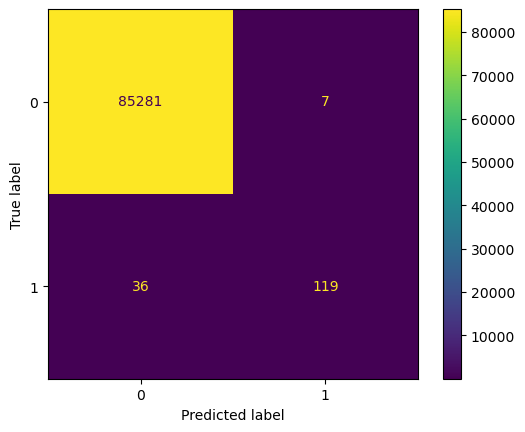

In [10]:
# A generic random forest classifier with 100 estimators

clf = RandomForestClassifier(n_estimators = 100, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('f1_score : ', f1_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


In [5]:

# gridsearch for a random forest using f1_macro
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the model to use
rf = RandomForestClassifier(random_state=42)

# Define the scoring metrics to use


# Perform the grid search
grid = GridSearchCV(
    rf, param_grid=param_grid, scoring='f1_macro', cv=2, n_jobs=-1, verbose=3
)
grid_result = grid.fit(X_scaled, y)



Fitting 2 folds for each of 81 candidates, totalling 162 fits


In [6]:
# Print the best hyperparameters and score for a random forest.
print("Best hyperparameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

Best hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best score:  0.9257026205508934


In [13]:
#decision tree grid search using f1_macro
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

clf = DecisionTreeClassifier(random_state = 0)
grid= GridSearchCV(clf, param_grid=param_grid, cv =5,return_train_score=True, n_jobs = 8, verbose = 2, scoring = 'f1_macro')
grid_result= grid.fit(X_scaled, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   4.2s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   4.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=2; total time=   4.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=10; total time=   4.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=20; total time=   4.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   4.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   4.2s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=10, min_samples_split=2; total time=   4.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=10, min_samples_split=10; total time=   4.1s
[CV] END criterion=gini, max_depth=3, min_sample

In [14]:

print(f'best f1_score: {grid_result.best_score_}')
print('best parameters :', grid_result.best_params_)


best f1_score: 0.9157052515826072
best parameters : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=20; total time=  15.7s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5; total time=  13.4s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=  12.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=5, min_samples_split=2; total time=  15.6s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=5, min_samples_split=5; total time=  14.5s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=5, min_samples_split=20; total time=  15.1s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=10, min_samples_split=5; total time=  13.1s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=10, min_samples_split=10; total time=  11.9s
[CV] END criterion=entropy, max_depth=Non